In [103]:
import sys

sys.path.append("..")

import time
import sqlite3
import pandas as pd
import numpy as np
import xgboost as xgb

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from utils import config

In [104]:
%%time
#Load data from the dataset
indicators = config.INDICATORS
separator = "','"
sql_read_query = f""" SELECT
                t2.CountryCode as Country,
                t1.Year,
                t3.IndicatorName,
                t1.Value                
                FROM CountryIndicators t1
                LEFT JOIN
                (SELECT ShortName as Country, CountryCode from Countries) t2
                ON t1.CountryCode = t2.CountryCode
                LEFT JOIN
                (SELECT IndicatorCode, IndicatorName from Indicators)t3
                ON t1.IndicatorCode = t3.IndicatorCode
                WHERE t3.IndicatorName in ('{separator.join(indicators)}');"""

with sqlite3.connect(config.DATABASE_PATH) as conn:
    country_indicators_df = pd.read_sql(sql_read_query,conn)

CPU times: user 5.93 s, sys: 64.3 ms, total: 5.99 s
Wall time: 5.99 s


In [105]:
#Features List
target = config.TARGET
gdp = config.GDP_GROWTH
pivoted_df = country_indicators_df.pivot(values='Value', index=['Country', 'Year'], columns=['IndicatorName'])

features = pivoted_df.columns.tolist()
print("Features Len:",len(features))
print(features)

Features Len: 49
['Adjusted net national income (annual % growth)', 'Adjusted net national income per capita (current US$)', 'Adjusted savings: education expenditure (% of GNI)', 'Adjusted savings: net national savings (% of GNI)', 'Agriculture, value added (annual % growth)', 'CO2 emissions (kt)', 'Crop production index (2004-2006 = 100)', 'Death rate, crude (per 1,000 people)', 'Export value index (2000 = 100)', 'Export volume index (2000 = 100)', 'Exports of goods and services (annual % growth)', 'External balance on goods and services (% of GDP)', 'External balance on goods and services (current LCU)', 'Food production index (2004-2006 = 100)', 'Foreign direct investment, net inflows (% of GDP)', 'Foreign direct investment, net inflows (BoP, current US$)', 'GDP deflator (base year varies by country)', 'GDP growth (annual %)', 'GDP per capita (current US$)', 'GDP per capita growth (annual %)', 'GDP per unit of energy use (PPP $ per kg of oil equivalent)', 'GNI growth (annual %)', 'G

In [107]:
#for indicator in features:
#    indicator_1 = country_indicators_df.loc[country_indicators_df["IndicatorName"] == indicator].copy()
#    indicator_1["Year"] += 1
#    indicator_1.set_index(["Country", "Year"], inplace=True)
#    indicator_1.rename(columns={"Value": "Previous "+indicator}, inplace=True)
#    indicator_1.drop(columns=["IndicatorName"], inplace=True)
#    pivoted_df = pivoted_df.join(indicator_1)

features = pivoted_df.columns.tolist()

target_df = country_indicators_df.loc[country_indicators_df["IndicatorName"] == gdp].copy()
target_df["Year"] -= 1
target_df.set_index(["Country", "Year"], inplace=True)
target_df.rename(columns={"Value": "Next GDP Growth"}, inplace=True)
target_df.drop(columns=["IndicatorName"], inplace=True)
df = pivoted_df.join(target_df)

df = df.dropna(subset=[target])  # Drop row if target is not present
df.shape

(9057, 50)

In [34]:
# Test-train split
X, y = df.iloc[:,:-1], df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (6339, 49)
X_test shape: (2718, 49)
y_train shape: (6339,)
y_test shape: (2718,)


In [35]:
# Init model
xg_reg = xgb.XGBRegressor(**config.XG_PARAMS)

In [109]:
# Train and test
t0 = time.time()
xg_reg.fit(X_train, y_train)
print(f"Elapsed time training: {time.time() - t0} seconds")
t0 = time.time()
xg_reg_y_pred = xg_reg.predict(X_test)
print(f"Elapsed time predicting: {time.time() - t0} seconds")

results_df = X_test
results_df = results_df.drop(columns=features)
results_df["y_real"] = y_test
results_df["y_pred"] = xg_reg_y_pred
results_df["err"] = np.absolute(results_df["y_real"] - results_df["y_pred"])
results_df["%_err"] = ((results_df["err"]) /(np.absolute (results_df["y_real"]))* 100)

print(f"RMSE: {mean_squared_error(y_test, xg_reg_y_pred)**0.5}")
print(f"R^2: {r2_score(y_test, xg_reg_y_pred)}")

results_df 

RMSE: 5.161150756365517
R^2: 0.2264449591406571


,,y_real,y_pred,err,%_err
Country,Year,,,,
ALB,1982,1.104938,3.051847,1.946909,176.200699
GHA,1983,8.647569,1.468752,7.178817,83.015434
HTI,2007,0.843944,3.848810,3.004866,356.050247
COG,1977,6.359747,-1.282841,7.642588,120.171263
MNA,1996,3.052934,4.581749,1.528816,50.076934
...,...,...,...,...,...
CRI,2008,-1.015719,2.262132,3.277851,322.712384
MIC,1986,4.469074,3.657300,0.811775,18.164268
MEX,2004,3.032574,4.064568,1.031994,34.030300


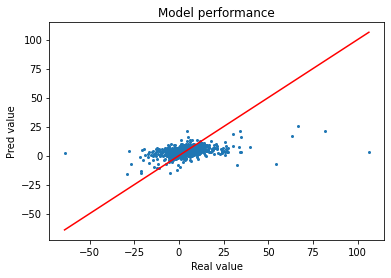

In [11]:
#Predicted Value Plot

fig, ax = plt.subplots()
plot_range = [results_df["y_real"].min(), results_df["y_real"].max()] 
ax.set_title("Model performance")
ax.set_ylabel("Pred value")
ax.set_xlabel("Real value")

ax.scatter(results_df["y_real"], results_df["y_pred"], s=4)
ax.plot(plot_range, plot_range, c="red")
plt.show()

In [100]:
# Prediction for 2010, using the last indicators info
# To do: write the info into data-base
pivoted_df = country_indicators_df.pivot(values='Value', index=['Country', 'Year'], columns=['IndicatorName'])
country_list = pivoted_df.index.unique('Country')

#Dataframe with all the countries
predictions = pd.DataFrame(country_list) 

#for country in country_list: 
predictions["Year"] = config.NEXT_YEAR
predictions["Value"] = xg_reg.predict(pivoted_df.filter(like = f"{config.NEXT_YEAR}", axis=0))
predictions.rename(columns={'Country': 'CountryCode'}, inplace=True)
predictions

,CountryCode,Year,Value
0,ABW,2010,1.685222
1,ADO,2010,-1.812026
2,AFG,2010,5.701902
3,AGO,2010,2.393778
4,ALB,2010,4.127574
...,...,...,...
242,YEM,2010,3.986965
243,ZAF,2010,2.822271
244,ZAR,2010,7.072944
245,ZMB,2010,8.766299


In [45]:
with sqlite3.connect(config.DATABASE_PATH) as conn:
    predictions.to_sql('EstimatedGDPGrowth', conn, if_exists='replace', index = False)

In [38]:
data_sql = [(1,3),(4,6),(7,9)]


def insert_database(predictions):
    sqlite_insert_query = f"""INSERT INTO EstimatedGDPGrowth
                          (CountryCode, Year, Value) 
                           VALUES 
                          (?, 2010, ?)"""
    try:
        with sqlite3.connect(config.DATABASE_PATH) as conn:
            cursor = conn.cursor()
            count = cursor.executemany(sqlite_insert_query, predictions)
            conn.commit()
            cursor.close()
    except sqlite3.Error as error:
        print(error)

insert_database(data_sql)

Incorrect number of bindings supplied. The current statement uses 2, and there are 7 supplied.


In [20]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(xg_reg)

In [21]:
%%time
shap_values = explainer.shap_values(X_test)

CPU times: user 5.86 s, sys: 7.95 ms, total: 5.87 s
Wall time: 953 ms


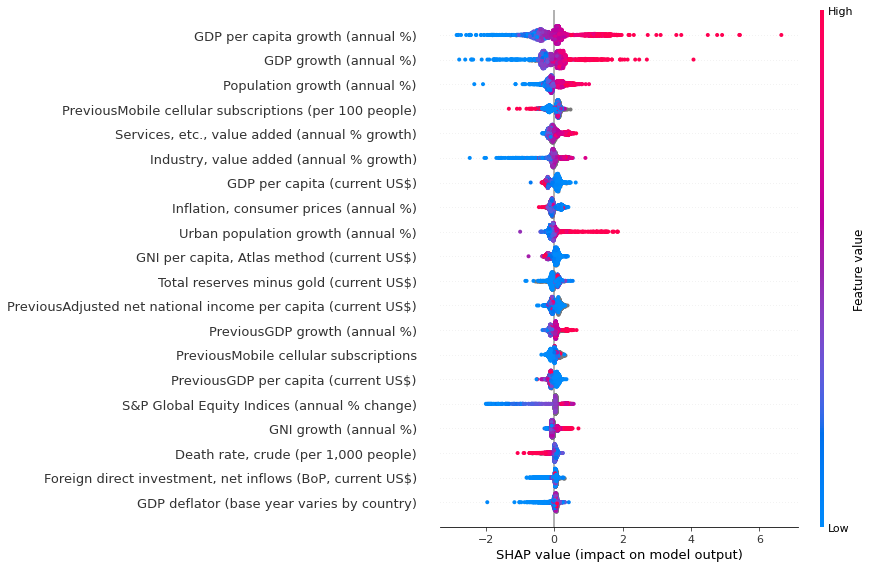

In [26]:
shap.summary_plot(shap_values, X_test,feature_names=features)

In [46]:
shap.summary_plot(shap_values, X_test, plot_type="bar",feature_names=features)

NameError: name 'shap' is not defined

In [23]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
important_features = feature_importance['col_name'].head(49).values.tolist()
important_features

['GDP per capita growth (annual %)',
 'GDP growth (annual %)',
 'Population growth (annual %)',
 'PreviousMobile cellular subscriptions (per 100 people)',
 'Services, etc., value added (annual % growth)',
 'Industry, value added (annual % growth)',
 'GDP per capita (current US$)',
 'Inflation, consumer prices (annual %)',
 'Urban population growth (annual %)',
 'GNI per capita, Atlas method (current US$)',
 'Total reserves minus gold (current US$)',
 'PreviousAdjusted net national income per capita (current US$)',
 'PreviousGDP growth (annual %)',
 'PreviousMobile cellular subscriptions',
 'PreviousGDP per capita (current US$)',
 'S&P Global Equity Indices (annual % change)',
 'GNI growth (annual %)',
 'Death rate, crude (per 1,000 people)',
 'Foreign direct investment, net inflows (BoP, current US$)',
 'GDP deflator (base year varies by country)',
 'Short-term debt (% of total reserves)',
 'PreviousUrban population growth (annual %)',
 'PreviousAdjusted savings: education expenditure 